In [1]:
#  libraries

import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

In [6]:
# import 
# Wrangle data

def wrangle(db_path):
    
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col = "b_id")
    
    #Identify leaky columns
    drop_cols =[ col for col in df.columns if "post_eq" in col ]
    
    #creat binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    #drop old target
    drop_cols.append("damage_grade")
    
    #drop  multicollinearity
    drop_cols.append("count_floors_pre_eq")

    #drop high cardinality categorical columns
    drop_cols.append("building_id")
    
    #drop columns
    df.drop(columns= drop_cols, inplace= True)

    
    return df

In [ ]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

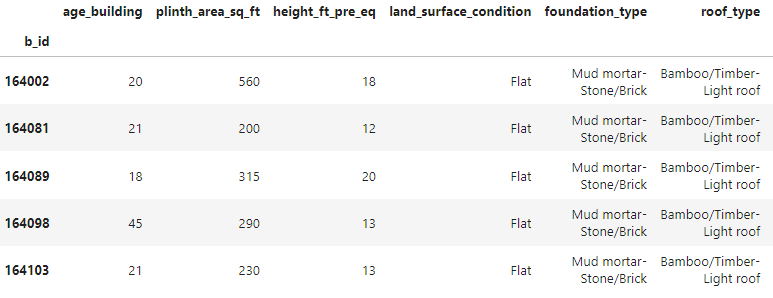

*Explore

Since our model will be a type of linear model, we need to make sure there's no issue with multicollinearity in our dataset

In [ ]:

# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()

# Plot heatmap of `correlation`
sns.heatmap(correlation)

# we have to change wrangle function so that it drops the "count_floors_pre_eq" 

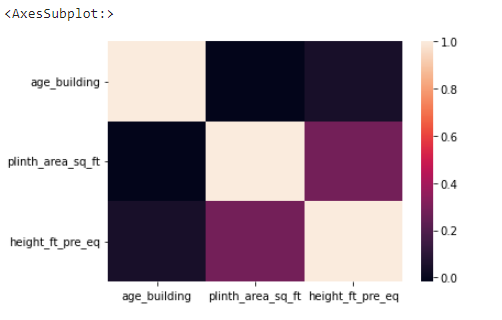

Using seaborn to create a boxplot that shows the distributions of the "height_ft_pre_eq" column
for both groups in the "severe_damage" column


In [ ]:
# Create boxplot
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)

# Label axes
plt.xlabel("Severe_damage")
plt.ylabel("Height Pre-earthquake [ft.]")
plt.title("Distribution of building height by class");


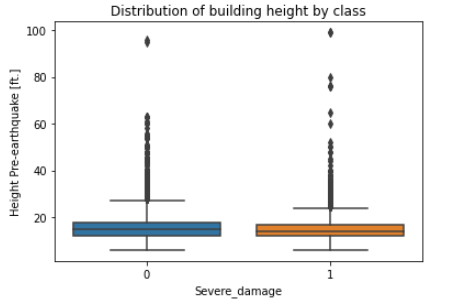

Evaluate the balance between our two classes. What percentage were severely damaged, what percentage were not?
Class Balance Barchart


In [ ]:
# Plot value counts of `"severe_damage"`
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"
);

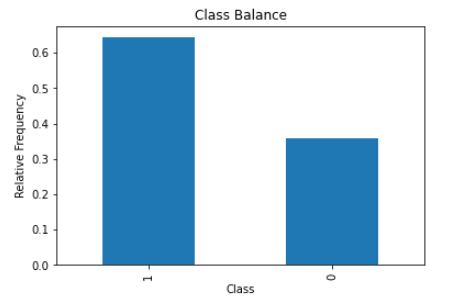

Majority and Minority Classes
Creating two variables, majority_class_prop and minority_class_prop, 
to store the normalized value counts for the two classes in df["severe_damage"]

In [ ]:
majority_class_prop, minority_class_prop =df["severe_damage"].value_counts(normalize=True) 
print(majority_class_prop, minority_class_prop)

To see are buildings with certain foundation types more likely to suffer severe damage must create a pivot table of df
where the index is "foundation_type" and the values come from the "severe_damage" column, aggregated by the mean


In [ ]:
# Create pivot table
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage",  aggfunc=np.mean
). sort_values(by="severe_damage")
foundation_pivot

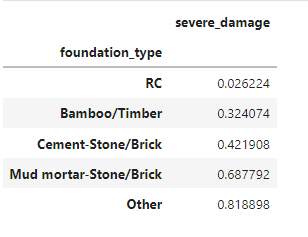

Bar Chart : Damage by Foundation

In [ ]:
# Plot bar chart of `foundation_pivot`
foundation_pivot.plot(kind="barh")
plt.axvline(
    majority_class_prop, linestyle="--", color= "red" , label= "Majority class"
)
plt.axvline(
    minority_class_prop, linestyle="--", color= "green", label="minority class"
)
plt.legend(loc= "lower right");

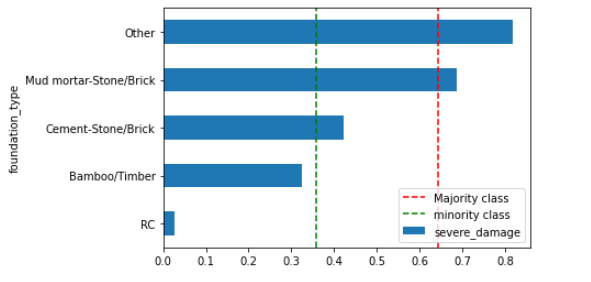

* Split

Creating feature matrix X and target vector y. The target is "severe_damage"

Randomized Trian Test Split

In [ ]:
target = "severe_damage"
X = df.drop(columns=target) 
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

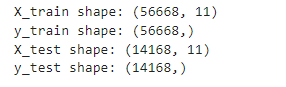

*Build Model
Calculating the baseline accuracy score for the model.

In [ ]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

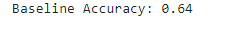

*Itarate

*Logistic Regression

Creating a pipeline named model that contains a OneHotEncoder transformer and a LogisticRegression predictor.

In [ ]:
# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter= 1000)
)
# Fit model to training data
model.fit(X_train, y_train)

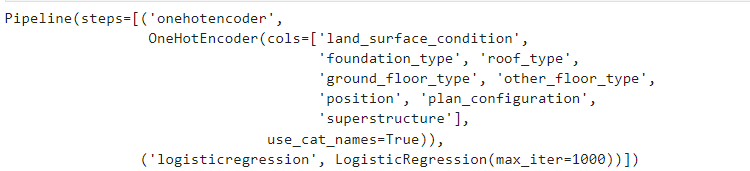

* Evaluate Model

Calculating the training and test accuracy scores for the models.

In [ ]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

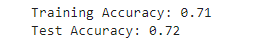

* Communicate

Prediction of Probability

In [ ]:
y_train_pred_proba = model.predict_proba(X_train)
-print(y_train_pred_proba[:5])

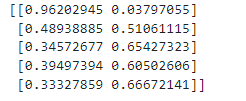

In [ ]:
model.predict(X_train)[:5]

Extracting the feature names and importances from the model

In [ ]:
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

 * Odds_ratios

In [ ]:
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()
odds_ratios.head()

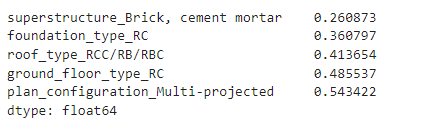

 Creating a horizontal bar chart with the five largest coefficients from odds_ratios.

In [ ]:
# Horizontal bar chart, five largest coefficients
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");

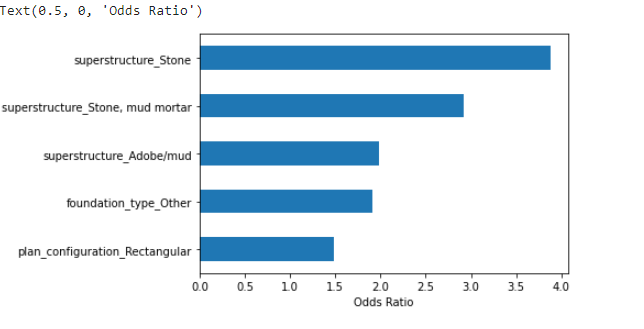

Creating a horizontal bar chart with the five smallest coefficients from odds_ratios

In [ ]:
# Horizontal bar chart, five smallest coefficients
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");

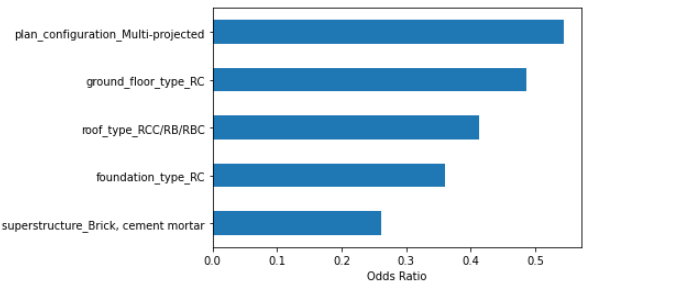

Results:
    The  fondation featutes can decrese or increase the percentage of sever damage of diffirenet buildings in an earthquake.